Uncomment and execute in Colab Notebooks

In [1]:
# execute this cell when loading the notebook for the first time
! pip install gensim==4.2.0
! pip install keras==2.8.0

! git clone https://github.com/michele98/POS_tagging


from google.colab import drive
drive.mount('/content/drive')

drive_folder = '/content/drive/MyDrive'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 21.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 7.9 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.8.0 which is incompatible.
Cloning into 'POS_tagging'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), 

In [2]:
# execute this cell each time the runtime is restarted

%cd -0
%cd POS_tagging

import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

/content
/content/POS_tagging


Main Imports

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import urllib.request

from zipfile import ZipFile

random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
#os.environ['TF_DETERMINISTIC_OPS'] = '1'

%load_ext autoreload
%autoreload 2

# Create Dataset

## Download data

In [4]:
dataset_folder = os.path.join(os.getcwd(), "Datasets", "Original")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

dataset_path = os.path.join(dataset_folder, "data.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")

Successful download


## Create Dataframe

In [5]:
train_range = (1, 101)
val_range = (101, 151)
test_range = (151, 200)

split_sentences = True

dataframe_rows = []
with ZipFile(dataset_path, 'r') as myzip:
    for i, filename in enumerate(myzip.namelist()[1:]):
        print("Extracting", filename, end='\r')

        with myzip.open(filename) as myfile:
            file_id = int(filename.split('.')[0][-4:])

            split = 'train'
            if file_id in range(*val_range):
                split = 'val'
            elif file_id in range(*test_range):
                split = 'test'

            content_string = myfile.read().decode('utf-8')
            if split_sentences:
                sentences = content_string.split('\n\n')
            else:
                sentences = [content_string]

            for sentence in sentences:
                content = sentence.split('\n')
                content = [line.split('\t') for line in content if len(line.split('\t')) == 3]

                words, tags, _ = zip(*content)

                dataframe_rows.append({'file_id': file_id,
                                       'text': words,
                                       'tags': tags,
                                       'split': split
                                       })

df = pd.DataFrame(dataframe_rows).sort_values('file_id').reset_index(drop=True)
print("Dataframe created.".ljust(50))

df

Dataframe created.                                


,file_id,text,tags,split
0,1,"(Pierre, Vinken, ,, 61, years, old, ,, will, j...","(NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",train
1,1,"(Mr., Vinken, is, chairman, of, Elsevier, N.V....","(NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",train
2,2,"(Rudolph, Agnew, ,, 55, years, old, and, forme...","(NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",train
3,3,"(``, There, 's, no, question, that, some, of, ...","(``, EX, VBZ, DT, NN, IN, DT, IN, DT, NNS, CC,...",train
4,3,"(Workers, described, ``, clouds, of, blue, dus...","(NNS, VBD, ``, NNS, IN, JJ, NN, '', WDT, VBD, ...",train
...,...,...,...,...
3909,198,"(A, line-item, veto, is, a, procedure, that, w...","(DT, JJ, NN, VBZ, DT, NN, WDT, MD, VB, DT, NN,...",test
3910,198,"(Sen., Kennedy, said, in, a, separate, stateme...","(NNP, NNP, VBD, IN, DT, JJ, NN, IN, PRP, VBZ, ...",test
3911,199,"(Trinity, Industries, Inc., said, it, reached,...","(NNP, NNPS, NNP, VBD, PRP, VBD, DT, JJ, NN, TO...",test
3912,199,"(Terms, were, n't, disclosed, .)","(NNS, VBD, RB, VBN, .)",test


## Preprocessing

Convert to lowercase

In [6]:
df['text'] = df['text'].apply(lambda l: [element.lower() for element in l])
df

,file_id,text,tags,split
0,1,"[pierre, vinken, ,, 61, years, old, ,, will, j...","(NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",train
1,1,"[mr., vinken, is, chairman, of, elsevier, n.v....","(NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",train
2,2,"[rudolph, agnew, ,, 55, years, old, and, forme...","(NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",train
3,3,"[``, there, 's, no, question, that, some, of, ...","(``, EX, VBZ, DT, NN, IN, DT, IN, DT, NNS, CC,...",train
4,3,"[workers, described, ``, clouds, of, blue, dus...","(NNS, VBD, ``, NNS, IN, JJ, NN, '', WDT, VBD, ...",train
...,...,...,...,...
3909,198,"[a, line-item, veto, is, a, procedure, that, w...","(DT, JJ, NN, VBZ, DT, NN, WDT, MD, VB, DT, NN,...",test
3910,198,"[sen., kennedy, said, in, a, separate, stateme...","(NNP, NNP, VBD, IN, DT, JJ, NN, IN, PRP, VBZ, ...",test
3911,199,"[trinity, industries, inc., said, it, reached,...","(NNP, NNPS, NNP, VBD, PRP, VBD, DT, JJ, NN, TO...",test
3912,199,"[terms, were, n't, disclosed, .]","(NNS, VBD, RB, VBN, .)",test


## Data Splitting

In [7]:
train_data = df[df['split'] == 'train']
val_data = df[df['split'] == 'val']
test_data = df[df['split'] == 'test']

x_train = train_data['text'].values
y_train = train_data['tags'].values

x_val = val_data['text'].values
y_val = val_data['tags'].values

x_test = test_data['text'].values
y_test = test_data['tags'].values

print('Dataset splits statistics: ')
print(f'Train data: {x_train.shape}')
print(f'Validation data: {x_val.shape}')
print(f'Test data: {x_test.shape}')


Dataset splits statistics: 
Train data: (1963,)
Validation data: (1299,)
Test data: (652,)


## Add OOV words to GloVe embeddings

In [8]:
from utils.preprocessing import load_embedding_model, add_OOV_embeddings

print("Loading GloVe embedding.")
my_embedding_dimension = 50
my_embedding_model = load_embedding_model('glove', my_embedding_dimension)

Loading GloVe embedding.
[=================================================-] 98.1% 64.7/66.0MB downloaded


In [9]:
print("GLOVE vocabulary size: ", len(my_embedding_model))

unknown_token = '[UNK]'
padding_token = ''

print(f"Add unknown token {unknown_token} and padding token {padding_token}")
add_OOV_embeddings(my_embedding_model, [unknown_token, padding_token], my_embedding_dimension)
print("V1 size: ", len(my_embedding_model))

print("\nCreating V2 using training set (V1 + OOV1)")
add_OOV_embeddings(my_embedding_model, x_train, my_embedding_dimension)
print("V2 size: ", len(my_embedding_model))

print("\nCreating V3 using validation set (V2 + OOV2)")
add_OOV_embeddings(my_embedding_model, x_val, my_embedding_dimension)
print("V3 size: ", len(my_embedding_model))

print("\nCreating V4 using validation set (V3 + OOV3)")
add_OOV_embeddings(my_embedding_model, x_test, my_embedding_dimension)
print("V4 size: ", len(my_embedding_model))

# build vocabulary for x
dataset_vocabulary = np.unique([word for sentence in df['text'] for word in sentence])
dataset_vocabulary = np.concatenate([[unknown_token], dataset_vocabulary])

# build vocabulary for y
tags_s = ' '.join([' '.join(y) for y in df['tags']])
tag_vocabulary = pd.DataFrame(tags_s.split())[0].unique()

GLOVE vocabulary size:  400000
Add unknown token [UNK] and padding token 


100%|██████████| 2/2 [00:00<00:00, 33.20it/s]


V1 size:  400002

Creating V2 using training set (V1 + OOV1)


100%|██████████| 359/359 [00:07<00:00, 46.84it/s]


V2 size:  400361

Creating V3 using validation set (V2 + OOV2)


100%|██████████| 189/189 [00:03<00:00, 48.97it/s]


V3 size:  400550

Creating V4 using validation set (V3 + OOV3)


100%|██████████| 128/128 [00:02<00:00, 46.21it/s]

V4 size:  400678


## Explore Tags and define punctuation tags

In [10]:
tag_vocabulary

array(['NNP', ',', 'CD', 'NNS', 'JJ', 'MD', 'VB', 'DT', 'NN', 'IN', '.',
       'VBZ', 'VBG', 'CC', 'VBD', 'VBN', '``', 'EX', "''", 'WDT', 'RB',
       'RP', 'TO', 'WRB', 'RBR', 'VBP', 'JJR', 'WP', 'JJS', 'PRP', ':',
       'POS', 'PRP$', '$', 'NNPS', 'WP$', '-LRB-', '-RRB-', 'PDT', 'RBS',
       'FW', 'UH', 'SYM', 'LS', '#'], dtype=object)

Mmh, there are some interesting looking tags. Let's build a DataFrame with some sentence examples to see what they mean.

In [11]:
d = {}

for tag in tag_vocabulary:
    i = df.loc[np.array([tag in t for t in df['tags']])].index[0]
    s1 = df['text'][i]
    t1 = df['tags'][i]
    d[f'{tag} (w)'] = np.pad(s1, (0,90-len(s1)))
    d[f'{tag} (t)'] = np.pad(t1, (0,90-len(t1)))

with open('phrase_examples.csv', 'w') as f:
    f.write(pd.DataFrame(d).to_csv())

After examining the resulting file, we know what the punctuation tags are. Let's put them in a list.

In [12]:
punctuation_tags = [',',
                    '.',
                    '``',
                    "''",
                    ':',
                    '-LRB-',
                    '-RRB-']

## Padding x

In [13]:
padding_length = int(df['tags'].apply(lambda x: len(x)).quantile(0.95))
print("The padding length is", padding_length)

dataset_dict = {k: i for i, k in enumerate(dataset_vocabulary)}

def tokenize_x(x):
    return [[dataset_dict[word] for word in phrase] for phrase in x]

x_train_tokenized = tokenize_x(x_train)
x_val_tokenized = tokenize_x(x_val)
x_test_tokenized = tokenize_x(x_test)

x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_tokenized, maxlen=padding_length, padding="post")
x_val_pad = tf.keras.preprocessing.sequence.pad_sequences(x_val_tokenized, maxlen=padding_length, padding="post")
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_tokenized, maxlen=padding_length, padding="post")

The padding length is 44


## Padding y

In [14]:
tag_dict = {k: i for i, k in enumerate(tag_vocabulary)}

def tokenize_y(y):
    return [[tag_dict[tag] for tag in phrase] for phrase in y]

y_train_tokenized = tokenize_y(y_train)
y_val_tokenized = tokenize_y(y_val)
y_test_tokenized = tokenize_y(y_test)

y_train_pad = tf.keras.preprocessing.sequence.pad_sequences(y_train_tokenized, maxlen=padding_length, padding="post")
y_val_pad = tf.keras.preprocessing.sequence.pad_sequences(y_val_tokenized, maxlen=padding_length, padding="post")
y_test_pad = tf.keras.preprocessing.sequence.pad_sequences(y_test_tokenized, maxlen=padding_length, padding="post")

# Train Models

In [15]:
from keras.optimizer_v2.adam import Adam
from keras.callbacks import ModelCheckpoint
from functools import partial

from utils.training_utils import MyHistory, plot_history
from models import embedding_layer

embedding_func = partial(embedding_layer,
                         vocabulary=dataset_vocabulary,
                         embedding_model=my_embedding_model,
                         embedding_dimension=my_embedding_dimension)

try:
    weights_folder = os.path.join(drive_folder, "weights")
except NameError as e:
    weights_folder = "weights"

checkpoint_partial = partial(ModelCheckpoint, monitor="val_loss", mode="auto")#, save_format="tf")
compile_args = dict(loss="sparse_categorical_crossentropy", metrics=["acc"])

input_shape = (padding_length, my_embedding_dimension)

## Baseline LSTM

Epoch 1/500
8/8 [==============================] - 4s 132ms/step - loss: 3.7878 - acc: 0.0684 - val_loss: 3.7559 - val_acc: 0.2263
Epoch 2/500
8/8 [==============================] - 0s 29ms/step - loss: 3.7388 - acc: 0.3667 - val_loss: 3.7079 - val_acc: 0.4647
Epoch 3/500
8/8 [==============================] - 0s 34ms/step - loss: 3.6892 - acc: 0.4811 - val_loss: 3.6584 - val_acc: 0.5092
Epoch 4/500
8/8 [==============================] - 0s 33ms/step - loss: 3.6374 - acc: 0.5160 - val_loss: 3.6058 - val_acc: 0.5332
Epoch 5/500
8/8 [==============================] - 0s 28ms/step - loss: 3.5811 - acc: 0.5332 - val_loss: 3.5475 - val_acc: 0.5430
Epoch 6/500
8/8 [==============================] - 0s 27ms/step - loss: 3.5180 - acc: 0.5395 - val_loss: 3.4804 - val_acc: 0.5443
Epoch 7/500
8/8 [==============================] - 0s 27ms/step - loss: 3.4436 - acc: 0.5402 - val_loss: 3.4000 - val_acc: 0.5425
Epoch 8/500
8/8 [==============================] - 0s 27ms/step - loss: 3.3533 - acc: 0.5

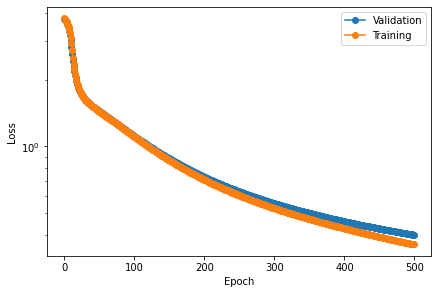

In [ ]:
from models import baselineLSTM

optimizer = Adam(learning_rate=1e-4)

checkpoint_path = os.path.join(weights_folder, "baseline", "checkpoint.hdf5")
history_path = os.path.join(weights_folder, "baseline", "history.npy")

checkpoint_callback = checkpoint_partial(filepath = checkpoint_path)
hist_callback = MyHistory(history_path)

model = baselineLSTM(num_classes=len(tag_vocabulary), input_shape=(padding_length,), embedding_func=embedding_func)
model.compile(**compile_args, optimizer=optimizer)

if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

history = model.fit(x=x_train_pad,
                    y=y_train_pad,
                    batch_size=256,
                    epochs=500,
                    validation_data=(x_val_pad,
                                     y_val_pad),
                    callbacks=[checkpoint_callback, hist_callback])

plot_history(history)

## GRU

Epoch 1/500
8/8 [==============================] - 3s 79ms/step - loss: 3.8208 - acc: 0.0232 - val_loss: 3.8008 - val_acc: 0.0273
Epoch 2/500
8/8 [==============================] - 0s 21ms/step - loss: 3.7905 - acc: 0.0309 - val_loss: 3.7715 - val_acc: 0.0349
Epoch 3/500
8/8 [==============================] - 0s 26ms/step - loss: 3.7605 - acc: 0.0380 - val_loss: 3.7423 - val_acc: 0.0414
Epoch 4/500
8/8 [==============================] - 0s 22ms/step - loss: 3.7306 - acc: 0.0468 - val_loss: 3.7130 - val_acc: 0.0511
Epoch 5/500
8/8 [==============================] - 0s 21ms/step - loss: 3.7004 - acc: 0.0542 - val_loss: 3.6833 - val_acc: 0.0563
Epoch 6/500
8/8 [==============================] - 0s 22ms/step - loss: 3.6697 - acc: 0.2195 - val_loss: 3.6529 - val_acc: 0.3953
Epoch 7/500
8/8 [==============================] - 0s 21ms/step - loss: 3.6380 - acc: 0.4190 - val_loss: 3.6214 - val_acc: 0.4425
Epoch 8/500
8/8 [==============================] - 0s 24ms/step - loss: 3.6051 - acc: 0.45

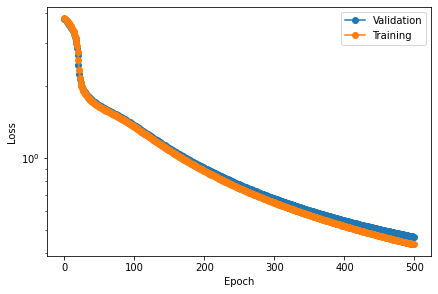

In [ ]:
from models import GRUModel

optimizer = Adam(learning_rate=1e-4)

checkpoint_path = os.path.join(weights_folder, "gru", "checkpoint.hdf5")
history_path = os.path.join(weights_folder, "gru", "history.npy")

checkpoint_callback = checkpoint_partial(filepath = checkpoint_path)
hist_callback = MyHistory(history_path)

model = GRUModel(num_classes=len(tag_vocabulary), input_shape=(padding_length,), embedding_func=embedding_func)
model.compile(**compile_args, optimizer=optimizer)

if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

history = model.fit(x=x_train_pad,
                    y=y_train_pad,
                    batch_size=256,
                    epochs=500,
                    validation_data=(x_val_pad,
                                     y_val_pad),
                    callbacks=[checkpoint_callback, hist_callback])

plot_history(history)

## Additional LSTM layer

Epoch 1/500
8/8 [==============================] - 7s 275ms/step - loss: 3.7498 - acc: 0.3156 - val_loss: 3.7001 - val_acc: 0.4764
Epoch 2/500
8/8 [==============================] - 0s 45ms/step - loss: 3.6554 - acc: 0.4971 - val_loss: 3.6062 - val_acc: 0.5010
Epoch 3/500
8/8 [==============================] - 0s 40ms/step - loss: 3.5547 - acc: 0.5157 - val_loss: 3.5016 - val_acc: 0.5091
Epoch 4/500
8/8 [==============================] - 0s 37ms/step - loss: 3.4392 - acc: 0.5200 - val_loss: 3.3772 - val_acc: 0.5097
Epoch 5/500
8/8 [==============================] - 0s 36ms/step - loss: 3.2986 - acc: 0.5204 - val_loss: 3.2219 - val_acc: 0.5099
Epoch 6/500
8/8 [==============================] - 0s 43ms/step - loss: 3.1221 - acc: 0.5205 - val_loss: 3.0232 - val_acc: 0.5100
Epoch 7/500
8/8 [==============================] - 0s 36ms/step - loss: 2.8958 - acc: 0.5200 - val_loss: 2.7724 - val_acc: 0.5099
Epoch 8/500
8/8 [==============================] - 0s 40ms/step - loss: 2.6208 - acc: 0.5

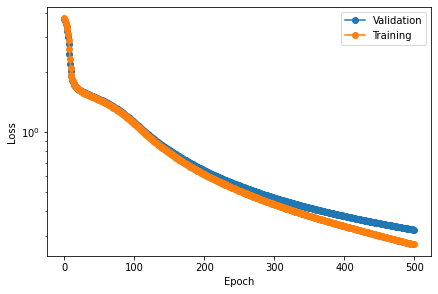

In [ ]:
from models import additionalLSTM

optimizer = Adam(learning_rate=1e-4)

checkpoint_path = os.path.join(weights_folder, "additionalLSTM", "checkpoint.hdf5")
history_path = os.path.join(weights_folder, "additionalLSTM", "history.npy")

checkpoint_callback = checkpoint_partial(filepath = checkpoint_path)
hist_callback = MyHistory(history_path)

model = additionalLSTM(num_classes=len(tag_vocabulary), input_shape=(padding_length,), embedding_func=embedding_func)
model.compile(**compile_args, optimizer=optimizer)

if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

history = model.fit(x=x_train_pad,
                    y=y_train_pad,
                    batch_size=256,
                    epochs=500,
                    validation_data=(x_val_pad,
                                     y_val_pad),
                    callbacks=[checkpoint_callback, hist_callback])

plot_history(history)

## Additional Dense

Epoch 1/500
8/8 [==============================] - 4s 145ms/step - loss: 0.9876 - acc: 0.6895 - val_loss: 1.0824 - val_acc: 0.6538
Epoch 2/500
8/8 [==============================] - 0s 34ms/step - loss: 0.9849 - acc: 0.6859 - val_loss: 1.0817 - val_acc: 0.6681
Epoch 3/500
8/8 [==============================] - 0s 31ms/step - loss: 0.9830 - acc: 0.6902 - val_loss: 1.0801 - val_acc: 0.6680
Epoch 4/500
8/8 [==============================] - 0s 31ms/step - loss: 0.9818 - acc: 0.6920 - val_loss: 1.0800 - val_acc: 0.6637
Epoch 5/500
8/8 [==============================] - 0s 31ms/step - loss: 0.9807 - acc: 0.6918 - val_loss: 1.0788 - val_acc: 0.6674
Epoch 6/500
8/8 [==============================] - 0s 30ms/step - loss: 0.9797 - acc: 0.6920 - val_loss: 1.0783 - val_acc: 0.6683
Epoch 7/500
8/8 [==============================] - 0s 28ms/step - loss: 0.9787 - acc: 0.6924 - val_loss: 1.0778 - val_acc: 0.6679
Epoch 8/500
8/8 [==============================] - 0s 30ms/step - loss: 0.9778 - acc: 0.6

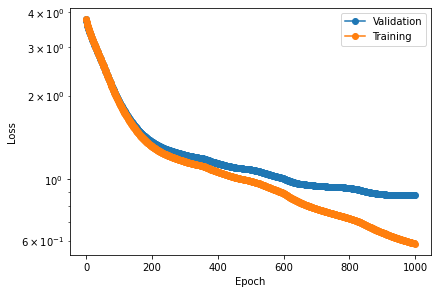

In [34]:
from models import additionalDense

optimizer = Adam(learning_rate=1e-3)

checkpoint_path = os.path.join(weights_folder, "additionalDense", "checkpoint.hdf5")
history_path = os.path.join(weights_folder, "additionalDense", "history.npy")

checkpoint_callback = checkpoint_partial(filepath = checkpoint_path)
hist_callback = MyHistory(history_path)

model = additionalDense(num_classes=len(tag_vocabulary), input_shape=(padding_length,), embedding_func=embedding_func)
model.compile(**compile_args, optimizer=optimizer)

if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

history = model.fit(x=x_train_pad,
                    y=y_train_pad,
                    batch_size=256,
                    epochs=500,
                    validation_data=(x_val_pad,
                                     y_val_pad),
                    callbacks=[checkpoint_callback, hist_callback])

plot_history(history)

# Performance Analysis

In [35]:
def flatten_data(list_of_lists):
    return [element for sequence in list_of_lists for element in sequence[:padding_length]]

def remove_punctuation(y, y_true=None):
    if y_true is None:
        y_true = y
    return [tag for tag, true_tag in zip(y, y_true) if true_tag not in punctuation_tags]

x_train_flattened = flatten_data(x_train)
x_val_flattened = flatten_data(x_val)
x_test_flattened = flatten_data(x_test)

y_train_flattened = flatten_data(y_train)
y_val_flattened = flatten_data(y_val)
y_test_flattened = flatten_data(y_test)

y_train_cleaned = remove_punctuation(y_train_flattened)
y_val_cleaned = remove_punctuation(y_val_flattened)
y_test_cleaned = remove_punctuation(y_test_flattened)

## Dummy Classifiers

In [36]:
from sklearn.dummy import DummyClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [37]:
majority_classifier = DummyClassifier(strategy="prior")
stratified_classifier = DummyClassifier(strategy="stratified")

majority_classifier.fit(x_train_flattened, y_train_flattened);
stratified_classifier.fit(x_train_flattened, y_train_flattened);

## Trained models

In [38]:
def unpad_result(y_padded, y_true):
    return [y[:len(yt)] for y, yt in zip(y_padded, y_true)]

def get_model_prediction(model, x, y_true):
    output = model.predict(x)
    y_pred_model = tag_vocabulary[np.argmax(output, axis=-1)]
    y_pred_unpadded = unpad_result(y_pred_model, y_true)
    return flatten_data(y_pred_unpadded)

In [39]:
from models import baselineLSTM, GRUModel, additionalLSTM, additionalDense

baseline = baselineLSTM(num_classes=len(tag_vocabulary), input_shape=(padding_length,), embedding_func=embedding_func)
baseline.load_weights(os.path.join(weights_folder, "baseline", "checkpoint.hdf5"))

gru = GRUModel(num_classes=len(tag_vocabulary), input_shape=(padding_length,), embedding_func=embedding_func)
gru.load_weights(os.path.join(weights_folder, "gru", "checkpoint.hdf5"))

additional_LSTM = additionalLSTM(num_classes=len(tag_vocabulary), input_shape=(padding_length,), embedding_func=embedding_func)
additional_LSTM.load_weights(os.path.join(weights_folder, "additionalLSTM", "checkpoint.hdf5"))

additional_dense = additionalDense(num_classes=len(tag_vocabulary), input_shape=(padding_length,), embedding_func=embedding_func)
additional_dense.load_weights(os.path.join(weights_folder, "additionalDense", "checkpoint.hdf5"))

## Build dictionary with prediction info
fill in this dictionary to get all the statistics

In [40]:
model_prediction_train = partial(get_model_prediction, x=x_train_pad, y_true=y_train)
model_prediction_val = partial(get_model_prediction, x=x_val_pad, y_true=y_val)
model_prediction_test = partial(get_model_prediction, x=x_test_pad, y_true=y_test)

remove_punctuation_train = partial(remove_punctuation, y_true=y_train_flattened)
remove_punctuation_val = partial(remove_punctuation, y_true=y_val_flattened)
remove_punctuation_test = partial(remove_punctuation, y_true=y_test_flattened)

prediction_data = [{
    'model_label': 'maj',
    'y_pred_train': remove_punctuation_train(majority_classifier.predict(x_train_flattened)),
    'y_pred_val': remove_punctuation_val(majority_classifier.predict(x_val_flattened)),
    'y_pred_test': remove_punctuation_test(majority_classifier.predict(x_test_flattened))
    }, {
    'model_label': 'stratified',
    'y_pred_train': remove_punctuation_train(stratified_classifier.predict(x_train_flattened)),
    'y_pred_val': remove_punctuation_val(stratified_classifier.predict(x_val_flattened)),
    'y_pred_test': remove_punctuation_test(stratified_classifier.predict(x_test_flattened))
    }, {
    'model_label': 'baseline',
    'y_pred_train': remove_punctuation_train(model_prediction_train(model=baseline)),
    'y_pred_val': remove_punctuation_val(model_prediction_val(model=baseline)),
    'y_pred_test': remove_punctuation_test(model_prediction_test(model=baseline))
    }, {
    'model_label': 'gru',
    'y_pred_train': remove_punctuation_train(model_prediction_train(model=gru)),
    'y_pred_val': remove_punctuation_val(model_prediction_val(model=gru)),
    'y_pred_test': remove_punctuation_test(model_prediction_test(model=gru))
    }, {
    'model_label': 'additionalDense',
    'y_pred_train': remove_punctuation_train(model_prediction_train(model=additional_dense)),
    'y_pred_val': remove_punctuation_val(model_prediction_val(model=additional_dense)),
    'y_pred_test': remove_punctuation_test(model_prediction_test(model=additional_dense))
    }, {
    'model_label': 'additionalLSTM',
    'y_pred_train': remove_punctuation_train(model_prediction_train(model=additional_LSTM)),
    'y_pred_val': remove_punctuation_val(model_prediction_val(model=additional_LSTM)),
    'y_pred_test': remove_punctuation_test(model_prediction_test(model=additional_LSTM))
    }
]

## Show analysis

Compute F1 score

In [41]:
import matplotlib.pyplot as plt

def analyze(y_true, y_pred, output_mode=0, model_label=None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    f1 = report['weighted avg']['f1-score']
    if output_mode >= 1:
        print(f"{model_label}, weighted F1 macro: {f1:.2f}")

    if output_mode >= 2:
        print("Confusion matrix")
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues')
        plt.show()
    return confusion_matrix(y_true, y_pred), f1

output_mode = 1
for data in prediction_data:
    for y, label in zip([y_train_cleaned, y_val_cleaned, y_test_cleaned], ['train', 'val', 'test']):
        res = analyze(y, data[f'y_pred_{label}'], output_mode=output_mode, model_label=f"{data['model_label']} {label}")
        data[f'cm_{label}'], data[f'f1_{label}'] = res

f1_train = [data['f1_train'] for data in prediction_data]
f1_val = [data['f1_val'] for data in prediction_data]
f1_test = [data['f1_test'] for data in prediction_data]

model_labels = [data['model_label'] for data in prediction_data]

maj train, weighted F1 macro: 0.04
maj val, weighted F1 macro: 0.05
maj test, weighted F1 macro: 0.05
stratified train, weighted F1 macro: 0.08
stratified val, weighted F1 macro: 0.08
stratified test, weighted F1 macro: 0.08
baseline train, weighted F1 macro: 0.73
baseline val, weighted F1 macro: 0.70
baseline test, weighted F1 macro: 0.74
gru train, weighted F1 macro: 0.69
gru val, weighted F1 macro: 0.67
gru test, weighted F1 macro: 0.70
additionalDense train, weighted F1 macro: 0.52
additionalDense val, weighted F1 macro: 0.37
additionalDense test, weighted F1 macro: 0.39
additionalLSTM train, weighted F1 macro: 0.78
additionalLSTM val, weighted F1 macro: 0.74
additionalLSTM test, weighted F1 macro: 0.78


Bar plot of F1 score

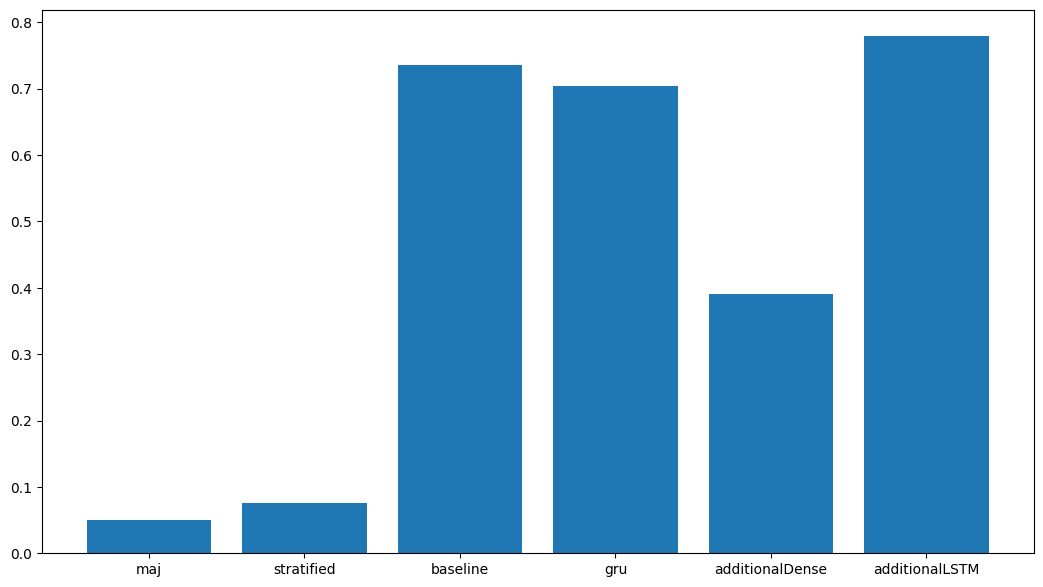

In [42]:
w, h, dpi = 1280, 720, 100
fig, ax = plt.subplots(figsize=(w/dpi, h/dpi), dpi=dpi)

ax.bar(model_labels, height=f1_test, width=0.8)
plt.show()